# Introduction and Domain Specification
* The dataset has 27.8k entries with 12 attributes. This compiled dataset pulled from four other datasets linked by time and place, and was built to find signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum. 
* **HDI for year** has missing values for more than 19K records which makes of around 70% of total no. of observations.
* Data is **missing for various countries for various years but in 2016, no suicides data is available for 85 countries**.
* Countries were cluubed in various **continents** using geonamescache packages.
* Multiple analysis can be done based on **groupping data** by :
    * age
    * sex
    * country
    * gdp_per_capita
    * year
* Suicide Rate is calculated by (total no. of suicides / total population)* 100000.




In [2]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#!pip install geonamescache
import geonamescache


# read data
suicides_data = pd.read_csv(r'D:\LECTURES\3rd Year\1st sem\DATA MINING 3\Mini Project\suicides.csv')

# Data Cleaning
* HDI for year is dropped, a spearated dataset is created where analysis is done based on HDI
* Countries for which suicide data is available for less than 10 years have been dropped
* Continents were mapped to countries
* Data for year 2016 is dropped due to very few observations

In [3]:
# Dropping HDI for year column due to 70% of missing observations
data = suicides_data.drop(['HDI for year'], axis = 1)

# Countries removed where data is avalable for less than 10 years only
by_countryYear = data.groupby('country')['year'].nunique().reset_index()
countries = list(by_countryYear[by_countryYear['year']>=10]['country'])
data = data[data['country'].isin(countries)]

# Mapped Continent to countries
gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
mapping = pd.DataFrame(countries).T.reset_index()[['name','continentcode']]
mapping.rename(columns = {'name':'country'}, inplace=True)
mapping['country'] = mapping['country'].replace({'Macao':'Macau',
                                   'Czechia':'Czech Republic',
                                   'South Korea':'Republic of Korea',
                                   'Russia':'Russian Federation',
                                   'Saint Vincent and the Grenadines':'Saint Vincent and Grenadines'})

data = pd.merge(data,mapping,on='country', how = 'left')
data['continentcode'] = data['continentcode'].replace({'EU':'Europe',
                                   'AS':'Asia',
                                   'NA':'North America',
                                   'SA':'South America',
                                   'AF':'Africa',
                                   'OC':'Oceania'})

# converting columns to catgegory data type
data['continentcode'] = pd.Categorical(data['continentcode'])
data['age'] = pd.Categorical(data['age'])
data['age'].cat.reorder_categories(['5-14 years','15-24 years','25-34 years',
                                    '35-54 years','55-74 years','75+ years'], inplace = True)
data['generation'] = pd.Categorical(data['generation'])
data['generation'].cat.reorder_categories(['G.I. Generation','Silent','Boomers','Generation X','Millenials','Generation Z'],
                                          inplace = True)
data['country'] = pd.Categorical(data['country'])
data['sex'] = pd.Categorical(data['sex'])
data.rename(columns = {'continentcode':'continent'},inplace = True)

# data for year 2016 is removed due to very less observations 
data = data[data['year'] != 2016]

# Data visualization and Analyzing

## Suicide Rate trend across year by continent, age group, gender and generations

#### Suicides Rate Across Globe - 
Suicides rates were increasing in the starting years, reached a maximum in 1995 and since then is decreasing across the globe.
Suicide rates are decreasing globally. (2.1)



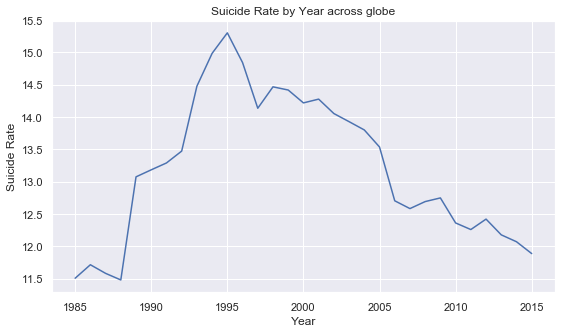

In [4]:
plt.figure(figsize=(9,5))
by_year = data.groupby(['year'])[['population','suicides_no']].sum().reset_index()
by_year['suicide_rate'] = by_year['suicides_no']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",data=by_year)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Year across globe')
plt.show()

#### Suicide Rates By Continent
* Remains constant in South America and North America, with ups and downs in Asia and Oceania continents.
* Highest rates have been observed in Europe where as lowest was seen in South America.
* There is sharpe descrease in suicde rates in Africa, after year 1995, indicating less data or issues in collecting data for countries in Africa.
* A decreasing trend is observed in Europe, still being the highes among all continents.

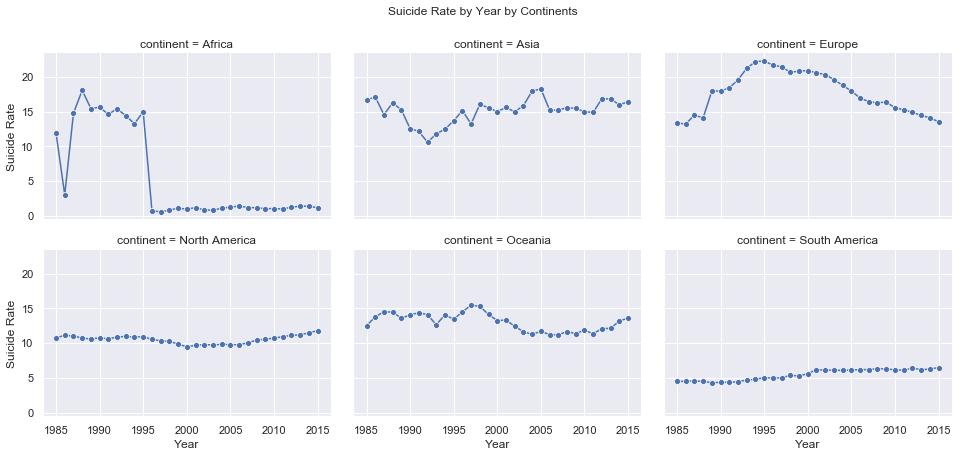

In [5]:
by_continent = data.groupby(['continent','year'])[['population','suicides_no']].sum().reset_index()
by_continent['suicide_rate'] = by_continent['suicides_no']*100000/by_continent['population']
sns.set_style("darkgrid")
ax = sns.relplot(x="year", y="suicide_rate", col="continent",col_wrap=3,
                 data=by_continent , kind="line", legend="full", marker='o',
                height=3, aspect=1.5)
ax.set(ylabel='Suicide Rate', xlabel='Year')
ax.fig.suptitle('Suicide Rate by Year by Continents', x=0.5, y=1.05)
plt.show()

#### Suicide Rates by Gender
* Males have very high suicide rate as compared to females.
* Globally, the rate of suicide for men has been ~3.5x higher for men
* Both male & female suicide rates peaked in 1995, declining since
* This ratio of 3.5 : 1 (male : female) has remained relatively constant since the mid 90’s
* However, during the 80’s this ratio was as low as 2.7 : 1 (male : female)

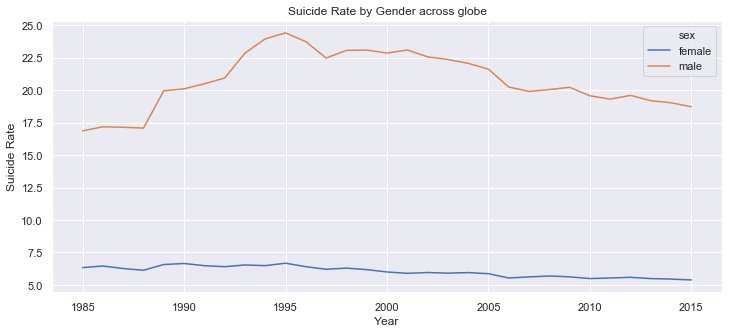

In [6]:
plt.figure(figsize=(12,5))
by_year = data.groupby(['year','sex'])[['population','suicides_no']].sum().reset_index()
by_year['suicide_rate'] = by_year['suicides_no']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",hue = 'sex',data=by_year,  legend="full")
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Gender across globe')
plt.show()




## As a country gets richer, does it’s suicide rate decrease?


* It depends on the country - for almost every country, there is a high correlation between year and gdp per capita, i.e. as time goes on, gdp per capita linearly increases.

* I calculated the correlations between ‘year’ and ‘GDP per capita’ within each country, then summarized the results:

* The  correlation was 0.34, indicating a very strong positive linear relationship.

* This basically means that looking within a country and asking “does an increase in wealth (per person) have an effect suicide rate” is pretty similar to asking “does a countries suicide rate increase as time progresses”.
 
* it depends on the country! Some countries are increasing with time, most are decreasing

C:\Users\ECOBEETA\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\ECOBEETA\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ECOBEETA\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

Correlation - MALE:
 suicides/100k pop     1.000000
age                   0.465832
generation            0.425920
gdp_per_capita ($)   -0.013263
year                 -0.037049
Name: suicides/100k pop, dtype: float64
Correlation - FEMALE:
 suicides/100k pop     1.000000
age                   0.377632
generation            0.366264
gdp_per_capita ($)    0.051648
year                 -0.082594
Name: suicides/100k pop, dtype: float64


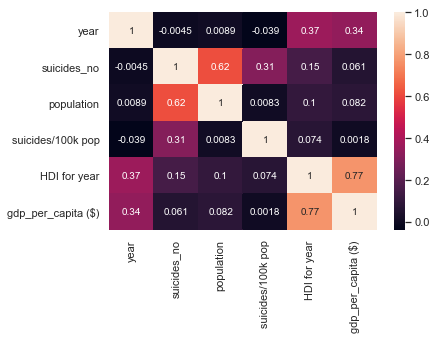

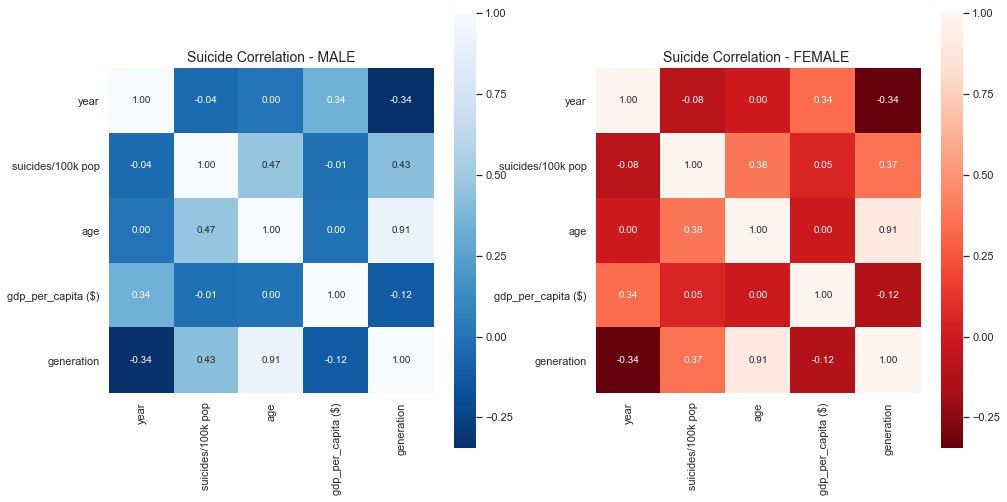

In [31]:
_ = sns.heatmap(suicides_data.corr(), annot=True)
df_unique_country = suicides_data['country'].unique() # to find total countries in the dataset
len(df_unique_country)

#  country, suicides_no, gdp_for_year ($) & year deleted from dataframe
corrData = suicides_data.drop(['country','suicides_no',' gdp_for_year ($) ',
                  'population','year'], axis=1)

# rearrange column name so "suicides/100k pop" is first
corrData = suicides_data[['year','suicides/100k pop', 'sex', 'age', 
             'gdp_per_capita ($)','generation']]

#  map sex, age, generation,continent
suicides_data['age'].groupby(suicides_data['generation']).value_counts()

corrData['sex'] = corrData['sex'].map({'female':0,'male':1})
corrData['age'] = corrData['age'].map({
        '5-14 years':0,'15-24 years':1,'25-34 years':2,
        '35-54 years':3,'55-74 years':4,'75+ years':5})
corrData['generation'] = corrData['generation'].map({
        'Generation Z':0,'Millenials':1,'Generation X':2,
        'Boomers':3,'Silent':4,'G.I. Generation':5})


#  Correlation MALE - filter dataframe for male/female
dataMale   = corrData[(corrData['sex'] == 1)]                       # male
dataMaleCorr = dataMale.drop(["sex"], axis=1).corr()        # male corr
print("Correlation - MALE:\n", dataMaleCorr['suicides/100k pop'].sort_values(ascending=False))

#  Correlation FEMALE - filter dataframe for male/female
dataFemale = corrData[(corrData['sex'] == 0)]                       # female
dataFemaleCorr = dataFemale.drop(["sex"], axis=1).corr()    # female corr
print("Correlation - FEMALE:\n", dataFemaleCorr['suicides/100k pop'].sort_values(ascending=False))

#  Correlation heatmaps for FEMALE/MALE
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
plt.title('Suicide Correlation - MALE', fontsize=14)
sns.heatmap(dataMaleCorr, annot=True, fmt='.2f', square=True, cmap = 'Blues_r')
fig.add_subplot(122)
plt.title('Suicide Correlation - FEMALE ', fontsize=14)
sns.heatmap(dataFemaleCorr, annot=True, fmt='.2f', square=True, cmap = 'Reds_r')
plt.show()

## Do richer countries have a higher rate of suicide?

* A very weak positive correlation is observed between suicide rate and country's GDP per capita, where it is also found that countries with high GDP have sucide rate more than 10.

* Instead of looking at trends within countries, here I take every country and calculate their mean GDP (per capita) across all the years in which data is available. I then measure how this relates to the countries suicide rate across all those years.

* The end result is one data point per country, intended to give a general idea of the wealth of a country and its suicide rate.

,gdp_per_capita ($),suicide_rate
gdp_per_capita ($),1.000000,0.088597
suicide_rate,0.088597,1.000000


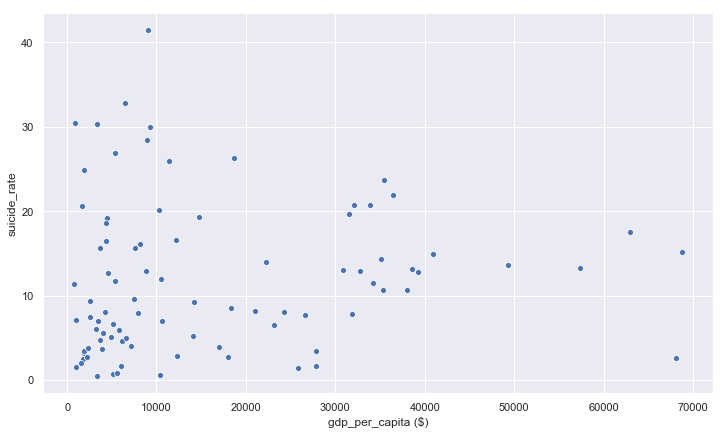

In [7]:
by_gdp_country = data.groupby(['country']).agg({'population':'sum', 
                         'suicides_no':'sum', 
                         'gdp_per_capita ($)':'mean'}).reset_index()
by_gdp_country['suicide_rate'] = by_gdp_country['suicides_no']*100000/by_gdp_country['population']
plt.figure(figsize=(12,7))
sns.scatterplot(x="gdp_per_capita ($)", y="suicide_rate", data=by_gdp_country)
by_gdp_country[['gdp_per_capita ($)','suicide_rate']].corr()

## By human development index 
As HDI for year column contains missing values to around 70%, the data si filtered for recent years i.e., 2012,2011,2012,2013 and 2014 and those countries were removed where data is missing for these years.

Coutries were divided based on the HDI categories -** Very High, High, Medium and Low**
**World map representing Human Development Index categories **
![World map representing Human Development Index categories ](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/2018_UN_Human_Development_Report.svg/1920px-2018_UN_Human_Development_Report.svg.png)
Source : [Wikipedia](https://en.wikipedia.org/wiki/Human_Development_Index)

This was found the, there exist a correlation of 0.43 (weak positive correlation) between suicide rates and HDI, indicating that suicide rates is high among countries with high human development index. 

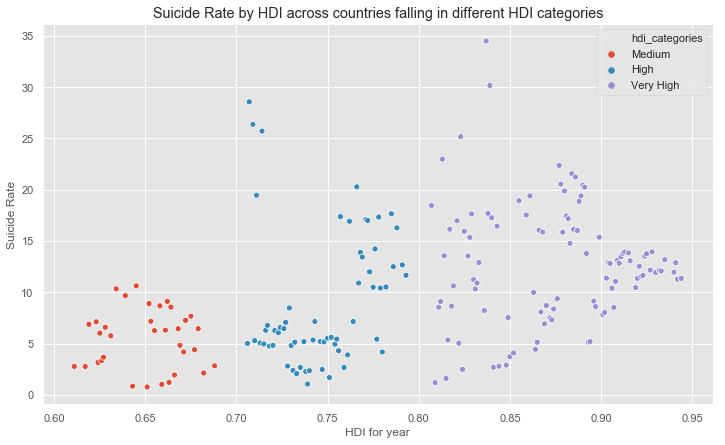

,HDI for year,suicide_rate
HDI for year,1.000000,0.426826
suicide_rate,0.426826,1.000000


In [16]:
# Basic Cleaning
data_withHDI = suicides_data.copy()
data_withHDI = data_withHDI[data_withHDI['HDI for year'].notnull()]

#data_withHDI.pivot_table(values = 'HDI for year',index = 'country',columns = 'year').isnull().sum()
# Filetred Years
data_withHDI = data_withHDI[data_withHDI['year'].isin([2010,2011,2012,2013,2014])]

# Filtered Countries
#data_withHDI.pivot_table(values = 'HDI for year',index = 'country',columns = 'year').isnull().sum()
countries = list(data_withHDI.pivot_table(values = 'HDI for year',index = 'country',columns = 'year') \
                 .dropna().reset_index()['country'])
data_withHDI = data_withHDI[data_withHDI['country'].isin(countries)]

#data_withHDI.pivot_table(values = 'HDI for year',index = 'country',columns = 'year').isnull().sum()
by_hdi = data_withHDI.groupby(['HDI for year'])[['population','suicides_no']].sum().reset_index()
by_hdi['suicide_rate'] = by_hdi['suicides_no']*100000/by_hdi['population']

# HDI Categories
by_hdi['hdi_categories'] = np.where(by_hdi['HDI for year'] >=0.8, "Very High",
                             np.where(by_hdi['HDI for year'].between(0.7,0.799), "High",
                             np.where(by_hdi['HDI for year'].between(0.555,0.699),"Medium","Low")))

# Plot and Correlation
plt.figure(figsize=(12,7))
plt.style.use('ggplot')
ax = sns.scatterplot(x="HDI for year", y="suicide_rate", hue= 'hdi_categories', data=by_hdi)
ax.set(ylabel='Suicide Rate', xlabel='HDI for year', title = 'Suicide Rate by HDI across countries falling in different HDI categories')
plt.show()
by_hdi[['HDI for year','suicide_rate']].corr()

## Countries with increasing/decreasing trend in suicide rate throughout the time period

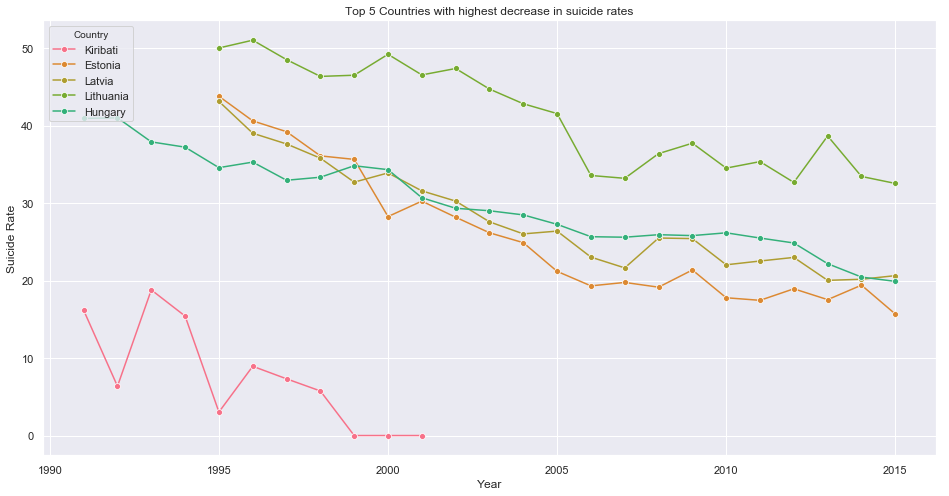

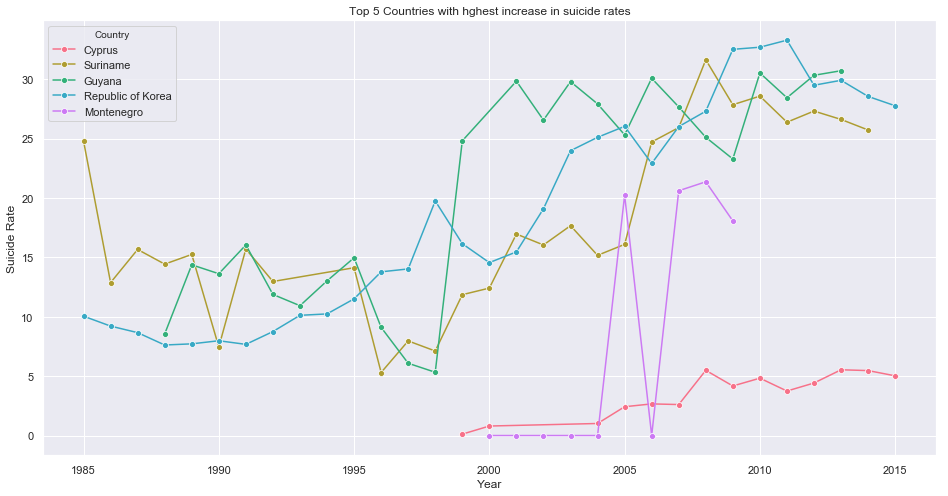

In [30]:
dm = data.groupby(['country','year'])['suicides_no','population'].sum().reset_index()
dm['suicide_rate'] = dm['suicides_no']*100000/dm['population']
dm = dm[dm['suicides_no'].notnull()]
from sklearn.linear_model import LinearRegression
b = [] 
for country in dm.country.unique():
    tempdf = dm[dm['country'] == country]
    X = np.asarray(tempdf['year']).reshape([-1,1])
    y = np.asarray(tempdf['suicide_rate']).reshape([-1,1])
    model = LinearRegression()
    results = model.fit(X,y).coef_[0][0]
    b.append([country,results])

df = pd.DataFrame(b,columns=['country','factor']).sort_values(by='factor')
decrease = list(df['country'].head(5))
increase = list(df['country'].tail(5))

plt.figure(figsize=(16,8))
leg = []
sns.set_palette("husl", 10)
for country in decrease:
    dm_country = dm[dm['country'] == country]
    ax = sns.lineplot(x="year", y="suicide_rate",data=dm_country, marker='o')
    leg.append(country)

plt.legend(title='Country', loc='upper left', labels=leg)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Top 5 Countries with highest decrease in suicide rates')
plt.show()


plt.figure(figsize=(16,8))
leg = []
sns.set_palette("husl", 5)
for country in increase:
    dm_country = dm[dm['country'] == country]
    ax = sns.lineplot(x="year", y="suicide_rate",data=dm_country, marker='o')
    leg.append(country)

plt.legend(title='Country', loc='best', labels=leg)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Top 5 Countries with hghest increase in suicide rates')
plt.show()

In [26]:
# #!pip install mlxtend
# from mlxtend.frequent_patterns import apriori
# from mlxtend.frequent_patterns import association_rules

# suicides_data.head()
# suicides_data.describe()

# # basket = (suicides_data[suicides_data['country' == 'Sri Lanka']
# #                        .groupby(['year','suicides/100k pop'])['gdp_per_capital($)']
# #                         .sum().unstack().reset_index().fillna(0)
                        
                        
# basket = (suicides_data[suicides_data['country'] == 'Sri Lanka']
#          .groupby(['year','suicides/100k pop'])['gdp_per_capita ($)']
#          .sum().unstack().reset_index().fillna(0))
#          # .set_index())
    
# def encode_units(x):
#   if x <= 0:
#     return 0
#   if x >= 1:
#     return 1
  


# basket_sets = basket.applymap(encode_units)
# #basket_sets.drop('POSTAGE',inplace=True, axis =1)

# frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)